### CTEM - BF image simulation


**Roberto dos Reis**<br>
Northwestern University

- Simulate an BF image using the partial coherent imaging model using weak phase object approximation.

- This script is based on [Kirkland's Advanced Computing in Electron Microscopy](https://www.springer.com/us/book/9781489995094#otherversion=9781441965325)


### Loading Packages

In [204]:
# Numeric operations
import numpy as np

# Visualization / Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import plotly.express as px

#to load .mat files
from scipy.io import loadmat

# for math functions
import scipy.special as sp
from scipy.interpolate import interp1d
from scipy.special import expit


# Ensure that images are rendered in this notebook:
%matplotlib inline

## Calculating Potentials

- This function Generates a Projected Potential using potentials from Kirkland suitable for TEM,  i.e intensity is proportional to Z^1/3

- Usage: ``V = tempot(xmax,ymax,nx,ny,potfile)``

- Inputs: 
    
    (xmax, ymax) are the size of the field of view in angstroms, 
    
    (nx, ny) are the number of pixels in the x and y directions 
    
    
- The electron and X-ray scattering factors for all neutral atoms with atomic numbers Z=2 through Z=103 were calculated using the relativistic Hartree-Fock program.

In [305]:
def tempot(xmax,ymax,nx,ny,potfile):
    zed =2 #0.67;  # zed=2 for rutherford scattering of the nucleus, less for screening
    ix = np.arange(1,nx+1)
    iy = np.arange(1,ny+1)
    
    dx = xmax/(nx-1)
    dy = ymax/(ny-1)
    rx = np.arange(0,(xmax-dx),dx)
    ry = np.arange(0,(ymax-dy),dy)
    
    # Loading atomic positions from potfile
    M = np.loadtxt(potfile, delimiter=',')
    Zatom = M[:,0]
    ax= M[:,1]
    ay=M[:,2]
    az =M[:,3]
    wt=M[:,4]
    tds=0
    amax = len(Zatom)
    
    #find boundaries of the axes
    axmin = ax.min(0)
    axmax = ax.max(0)
    aymin = ay.min(0)
    aymax = ay.max(0)
    
    #shift coords to fit in box
    ax = ax - axmin
    ay = ay - aymin
    
    V= np.zeros((nx,ny))
    
    # map x and y coords of the atoms to the nearest grid points
    # A fraction of the atom must be assigned to the closest gridpoints
    # to avoid sum and difference frequencies appearing in the image
    
    #grid point to the left of the atom
    iax = np.maximum(1,np.minimum(np.floor(ax/dx)+1,nx)).astype(int)
    iax = iax -1
    
    #create periodic boundary conditions
    ibx = np.mod(iax,nx) #+ 1
    
    #fraction of atom at iax 
    fax = 1-np.mod((ax/dx),1)
    
    #grid point above the atom
    iay = np.maximum(1,np.minimum(np.floor(ay/dy)+1,ny)).astype(int) 
    iay = iay-1
    
    #create periodic boundary conditions
    iby = np.mod(iay,ny) #+1
    
    #fraction of atom at iay
    fay = 1-np.mod((ay/dy),1)
    
    #Add each atom to the potential grid j is too large to makegrid(iax,iay) which would allow us to vectorize V
    V1 = fax*fay*(Zatom**zed)
    V2 = (1-fax)*fay*(Zatom**zed)
    V3 = fax*(1-fay)*(Zatom**zed)
    V4 = (1-fax)*(1-fay)*(Zatom**zed);
    
    for a0 in range(0,amax):
        V[iax[a0],iay[a0]] = V[iax[a0],iay[a0]] + V1[a0]
        V[ibx[a0],iay[a0]] = V[ibx[a0],iay[a0]] + V2[a0]
        V[iax[a0],iby[a0]] = V[iax[a0],iby[a0]] + V3[a0]
        V[ibx[a0],iby[a0]] = V[ibx[a0],iby[a0]] + V4[a0]
        
    
    return V

### Plotting Projected Potential

In [359]:
v = tempot(30,30,64,64,'Si_7x5.dat')

In [360]:
fig = px.imshow(abs(v), color_continuous_scale='sunset')

fig.update_layout(coloraxis_showscale=True)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

### Function to calculate CTEM bright field contrast transfer function with partial coherence for weak phase objects

input array k has the spatial frequency values (in 1/A)
input array params has the optical parameters


    - input type = 0 for phase contrast 
    - input type = 1 for amplitude contrast 
    
    Output array contains the transfer function vs k

  params= [Cs, df, kev, ddf, beta]
  
  Cs   = spherical aberration (in mm)
  df   = defcocus (in Angstroms)
  kev  = electron energy (in keV)
  ddf  = chromatic aberation defocus spread (in Angstroms)
  beta = spread in illumination angles (in mrad)

In [361]:
def ctemincohmtf(k,params, type):
    Cs = params[0]*1.0e7
    df = params[1]
    kev = params[2]
    ddf = params[3]
    beta = params[4]*0.001;
    
    #Electron Wavelength
    wav = 12.3986/np.sqrt((2*511.0+kev)*kev)
    K = (Cs*wav**3)**0.25*k                 #dimensionless k
    Ks = (Cs*wav**3)**0.25*beta/wav          #dimensionless k straggle
    D = df/np.sqrt(Cs*wav)                    #dimensionless defocus
    Ds = ddf/np.sqrt(Cs*wav)                  #dimensionless defocus straggle
    E = (np.pi**2)*(Ks**2)*(Ds**2)                     #dimensionless epsilon
    
    K2 = K*K                                 #K^2
    base = 1+E*K2                         #1+E*K^2
    prefactor = 1/np.sqrt(base);              #1/(1+E*K^2)^(1/2)
    
    wr = np.pi*(K2/base)*(0.5*K2*(1-E*K2)-D)
    wi = prefactor*np.exp(-(np.pi**2*(Ks**2)*(K2-D)**2*K2 + 0.25*np.pi**2*Ds**2*K2**2)/base)
    
    if type == 0:
        mtf = np.sin(wr)*wi
    else:
        mtf = np.cos(wr)*wi
        
    return mtf

### Convolving PSF with Projected Potential 

- Function to convolve the CTEM PSF with the projected potential
- Input matrix V is the projected potential calculated above

* input rmax = radial limit
* input nx = dimension of V. i.e. V(nx,nx);
* input type = 0 for phase contrast and 1 for amplitude contrast

**Parameters**

params = [Cs, df, kev, ddf,beta, amax]

Cs   = spherical aberration (in mm)

df   = defcocus (in Angstroms)

kev  = electron energy (in keV)

ddf  = chromatic aberation defocus spread (in Angstroms)

beta = spread in illumination angles (in mrad)

amax = objective aperture semiangle in mrad

### Function to convolve the CTEM PSF with the projected potential

In [362]:
def ctemconvolution(V,rmax,nx,params,type): 
    Cs = params[0]*1.0e7
    df = params[1]
    kev = params[2]
    ddf = params[3]
    beta = params[4]*0.001
    amax = params[5]*0.001
    
    wav = 12.3986/np.sqrt((2*511.0+kev)*kev)
    klimit = amax/wav
    
    V = np.fft.fft2(V)
    dx = rmax/nx
    kmax = 1/dx
    dk = 1/(dx*nx)

    k0= np.arange(-kmax/2,kmax/2,dk)
    k1= np.arange(-kmax/2,kmax/2,dk)
    
    kx, ky = np.meshgrid(k0,k1)
    k2 = np.fft.fftshift(np.sqrt(kx**2+ky**2))
    
#     del kx
#     del ky
    
    #Here we call another function
    H2d = ctemincohmtf(k2,params,type)
    
    klimit = np.minimum(klimit,kmax/2)
    
    #replace step by 1/(1+exp(A*(x-xc)))
#     x = np.arange(0,kmax,dk/4).astype('float64')
    x = np.linspace(0,kmax, num=int(kmax/dk))
    y = 1/(1+expit(1000*(x-klimit)))
    
    k2 = interp1d(x,y, kind='cubic')
    
    V = V*H2d
    V = V*k2(x)
    
    II = np.abs((np.fft.ifft2(V)))

    
    return II

### Enter the parameters

- params = [Cs, df, kev, ddf,beta, amax]

In [363]:
kev = 100  
Cs= 0.1  
df= 700 
ddf= 100
beta= 0
rmax = 30
nx = 64
amax = 9.33
potfile ='Si_7x5.dat'
type = 0

params = [Cs, df, kev, ddf,beta, amax]

In [364]:
V = tempot(rmax,rmax,nx,nx,potfile)
II = ctemconvolution(V,rmax,nx,params,type)

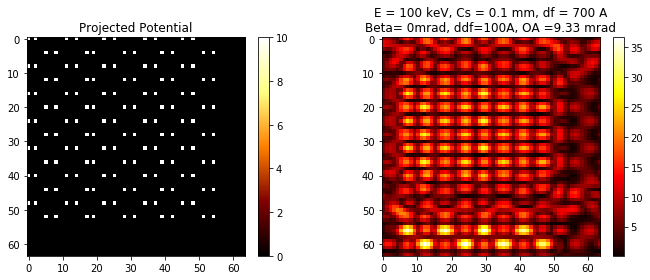

In [365]:
fig, axis = plt.subplots(ncols=2,figsize=(10, 4))

im_handle = axis[0].imshow(np.sqrt(V),cmap='afmhot',vmax=10)
axis[0].set_title('Projected Potential')

# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axis[0], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)


im_handle = axis[1].imshow(II,cmap='hot')
axis[1].set_title(f'E = {params[2]} keV, Cs = {params[0]} mm, df = {params[1]} A'
             +"\n"+
            f'Beta= {params[4]}mrad, ddf={params[3]}A, OA ={params[5]} mrad')


# Adding a colorbar:
cbar = plt.colorbar(im_handle, ax=axis[1], orientation='vertical',
fraction=0.046, pad=0.04, use_gridspec=True)

fig.tight_layout()